This project is "WhatsApp Group Chat Analysis".

Cell 1: Install & Import Libraries
We need matplotlib and seaborn for plotting, emoji to analyze emoji usage, and wordcloud for text visualization.

In [18]:
!pip install -q matplotlib seaborn emoji wordcloud pandas

import re
import pandas as pd
import numpy as np
import emoji
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

# Set plot style for better aesthetics
plt.style.use('ggplot')
sns.set_palette("husl")

print("✅ Libraries installed and imported.")

✅ Libraries installed and imported.


Cell 2: Create Dummy Data (for Testing)
Since you might not have a WhatsApp export file ready on your laptop right now, run this cell to generate a dummy chat.txt file. This allows you to test the entire pipeline immediately. Later, you can replace this with your real _chat.txt file.

In [19]:
# Create a dummy WhatsApp chat export file
dummy_chat_content = """[01/01/24, 10:00:00] Alice: Hey guys! Happy New Year! 🎆
[01/01/24, 10:05:00] Bob: Happy New Year Alice! Let's make this year great.
[01/01/24, 10:06:00] Charlie: Happy New Year everyone!
[01/01/24, 10:15:00] Alice: I am going to start learning Python this year.
[01/01/24, 10:20:00] Bob: That's a great resolution. I can help you with that.
[01/01/24, 11:00:00] Charlie: Does anyone want to grab coffee later?
[01/01/24, 11:05:00] Alice: I'm down! ☕
[01/01/24, 11:10:00] Bob: Me too. Let's meet at 5 PM.
[02/01/24, 09:00:00] Alice: Good morning!
[02/01/24, 09:15:00] Charlie: Morning! sending a photo...
[02/01/24, 09:15:05] Charlie: <Media omitted>
[02/01/24, 09:30:00] Bob: Nice photo! 😂
[03/01/24, 20:00:00] Alice: Did you guys see the match?
[03/01/24, 20:05:00] Bob: Yes! It was insane.
[03/01/24, 20:05:15] Bob: I can't believe we won.
[03/01/24, 20:10:00] Charlie: Best game ever. 🔥
"""

with open('chat.txt', 'w', encoding='utf-8') as f:
    f.write(dummy_chat_content)

print("✅ Dummy 'chat.txt' file created.")

✅ Dummy 'chat.txt' file created.


Cell 3: Parse the Data
This is the most critical step. WhatsApp exports are unstructured text. We use Regular Expressions (Regex) to split each line into Date, Time, Author, and Message.

Note: This parser is designed for the standard format [dd/mm/yy, hh:mm:ss] Author: Message. If your real file uses a different format (like Android's dd/mm/yy - Name:), you may need to adjust the regex slightly.

In [20]:
def parse_whatsapp_chat(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    # Regex to extract Date, Time, Author, and Message
    # Pattern: [Date, Time] Author: Message
    pattern = r'^\[(\d{2}/\d{2}/\d{2}), (\d{2}:\d{2}:\d{2})\] ([^:]+): (.*)'

    data = []

    for line in lines:
        match = re.match(pattern, line)
        if match:
            date, time, author, message = match.groups()
            data.append([date, time, author, message])
        else:
            # Handle multi-line messages (append to previous message)
            if data:
                data[-1][3] += " " + line.strip()

    df = pd.DataFrame(data, columns=['Date', 'Time', 'Author', 'Message'])

    # Convert Date/Time columns to datetime objects
    df['Date_Time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%y %H:%M:%S')
    df['Hour'] = df['Date_Time'].dt.hour
    df['Day_Name'] = df['Date_Time'].dt.day_name()

    return df

# Parse the file
df = parse_whatsapp_chat('chat.txt')
print("✅ Data Parsed Successfully.")
print(df.head())

✅ Data Parsed Successfully.
       Date      Time   Author  \
0  01/01/24  10:00:00    Alice   
1  01/01/24  10:05:00      Bob   
2  01/01/24  10:06:00  Charlie   
3  01/01/24  10:15:00    Alice   
4  01/01/24  10:20:00      Bob   

                                             Message           Date_Time  \
0                        Hey guys! Happy New Year! 🎆 2024-01-01 10:00:00   
1  Happy New Year Alice! Let's make this year great. 2024-01-01 10:05:00   
2                          Happy New Year everyone!  2024-01-01 10:06:00   
3     I am going to start learning Python this year. 2024-01-01 10:15:00   
4  That's a great resolution. I can help you with... 2024-01-01 10:20:00   

   Hour Day_Name  
0    10   Monday  
1    10   Monday  
2    10   Monday  
3    10   Monday  
4    10   Monday  


Cell 4: Analyze Activity Stats
Let's see who talks the most and what the busiest times are.

Total Messages: 16

Most Active Users:
Author
Bob        6
Alice      5
Charlie    5
Name: count, dtype: int64


/tmp/ipython-input-1731174741.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=author_counts.index, y=author_counts.values, palette='viridis')


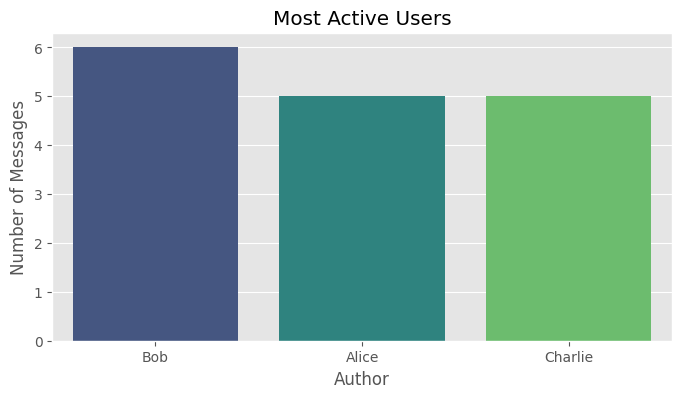

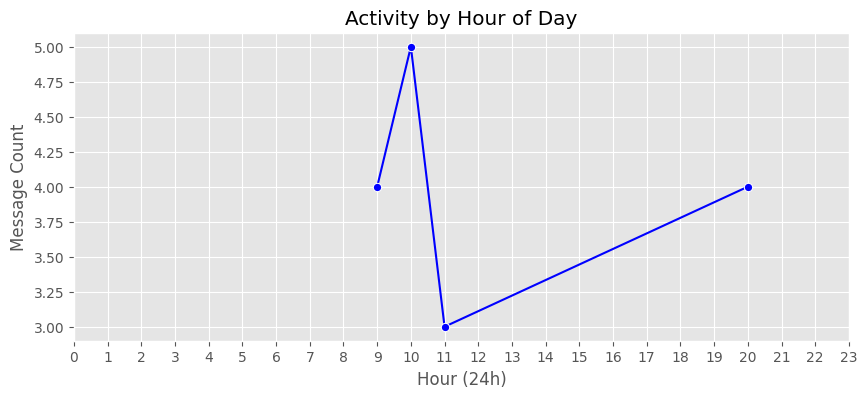

In [21]:
# 1. Total Messages
total_messages = df.shape[0]
print(f"Total Messages: {total_messages}")

# 2. Most Active Users
author_counts = df['Author'].value_counts()
print("\nMost Active Users:")
print(author_counts)

# 3. Plot Most Active Users
plt.figure(figsize=(8, 4))
sns.barplot(x=author_counts.index, y=author_counts.values, palette='viridis')
plt.title('Most Active Users')
plt.ylabel('Number of Messages')
plt.show()

# 4. Busiest Time of Day (Hour)
hourly_counts = df['Hour'].value_counts().sort_index()

plt.figure(figsize=(10, 4))
sns.lineplot(x=hourly_counts.index, y=hourly_counts.values, marker='o', color='b')
plt.title('Activity by Hour of Day')
plt.xlabel('Hour (24h)')
plt.ylabel('Message Count')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

Cell 5: Word Cloud & Emoji Analysis
This generates a visual cloud of the most used words and counts the top emojis.

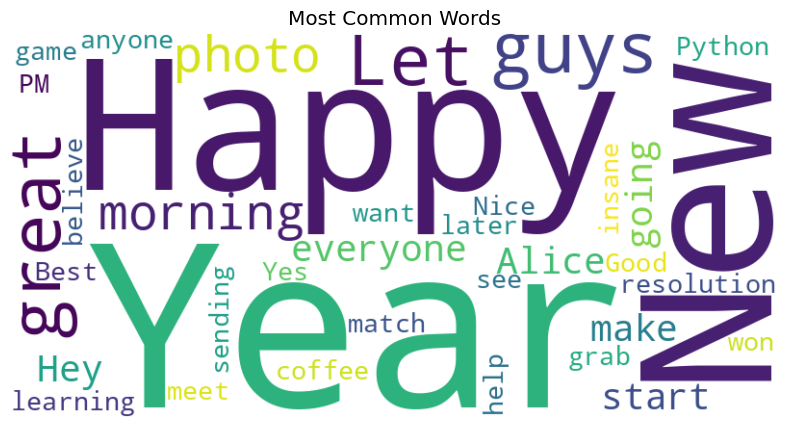


Top 5 Emojis Used:
🎆: 1
☕: 1
😂: 1
🔥: 1


In [22]:
# 1. Word Cloud
# Combine all messages into one string
text = " ".join(review for review in df.Message)

# Remove "Media omitted" (WhatsApp system message)
text = text.replace("<Media omitted>", "")

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words")
plt.show()

# 2. Emoji Analysis
def extract_emojis(text):
    return [c for c in text if c in emoji.EMOJI_DATA]

df['Emojis'] = df['Message'].apply(extract_emojis)
all_emojis = [e for sublist in df['Emojis'] for e in sublist]

emoji_counts = Counter(all_emojis).most_common(5)
print("\nTop 5 Emojis Used:")
for e, count in emoji_counts:
    print(f"{e}: {count}")